# Simulating Passive Dendritic Properties with NEURON and Python

This tutorial explores the fundamental principles of neuronal signaling by simulating the passive properties of a dendrite using the NEURON simulation environment and Python. We'll focus on understanding how electrical signals spread through a simplified dendritic cable and how to visualize the resulting voltage distribution.

## The Cable Equation

The foundation of neuronal signal propagation is the cable equation, a partial differential equation that describes how voltage changes over time and space in a cable-like structure:

$$\frac{a}{2}\frac{r_m}{r_i} \frac{\partial^2 V}{\partial x^2} = r_m\ c \frac{\partial V}{\partial t} + (V - E_m)$$

where:

* $V$ is the membrane potential
* $x$ is the distance along the cable
* $r_i$ is the (specific) axial resistance (resistance to current flow along the cable)
* $c$ is the (specific) membrane capacitance (ability of the membrane to store charge)
* $r_m$ is the (specific) membrane resistance (leak conductance)
* $E_m$ is the resting membrane potential

This equation captures the interplay between the passive properties of the neuronal membrane (resistance and capacitance) and the active currents that generate and shape electrical signals.

## NEURON Simulation and its Python interface

NEURON is a powerful simulation environment specifically designed for modeling neurons and neural networks. It provides a flexible framework for defining neuron morphologies, biophysical properties, and simulation parameters.

NEURON offers a Python interface that allows us to interact with the simulator using Python scripts. This enables us to leverage the versatility and ease of use of Python for constructing and running our simulations.

### Key Concepts

* **Sections:** In NEURON, neurons are represented as a collection of sections, each representing a segment of the neuron's morphology (e.g., dendrites, soma, axon).
* **Mechanisms:**  Sections can be endowed with various biophysical mechanisms, such as passive membrane properties (`pas`) or active ion channels (e.g., Hodgkin-Huxley).
* **Segments:**  Sections are further divided into segments, which are the fundamental units for numerical simulation. The number of segments (`nseg`) determines the spatial resolution of the simulation.

## Simulating a Passive Dendrite

We simulate here a single dendritic cable with passive properties. We inject current at one end (or at the mid point of the dendrite), and observe how the voltage spreads along the cable.

### Steps

1. **Initialize NEURON:** Import the necessary modules and load the standard run environment.
2. **Create a section:** Define a `Section` object to represent the dendrite.
3. **Set morphology:** Specify the length (`L`), diameter (`diam`), and number of segments (`nseg`) of the dendrite.
4. **Set biophysical properties:** Assign values for axial resistance (`Ra`), membrane capacitance (`cm`), leak conductance (`g`), and resting potential (`e`).
5. **Inject current:** Create an `IClamp` object to inject current at a specific location on the dendrite.
6. **Record voltage:**  Define recording vectors to store the membrane potential at different locations along the dendrite.
7. **Run simulation:** Use `h.run()` to execute the simulation.
8. **Analyze results:** Plot the voltage distribution along the dendrite to visualize the spatial spread of the signal.

In [11]:
!pip3 install neuron   # This should be run only once. It installs the
                        # NEURON simulator and its Python interface...

In [41]:
# @title Python libraries includes
from neuron import h              # Import the NEURON-Python library
import matplotlib.pyplot as plt   # matplotlib for plotting
import numpy as np                # numpy for linspace and other goodies

h.load_file('stdrun.hoc')         # Standard simulation environment of NEURON

#----------------------------------------------------------------------------
dend      = h.Section()    # Create a section (cable) and set its morphology...
L  = 10.                   # Length   [micrometers]
a  = 2.                    # Radius [micrometers]

c  = 1.                 # Mem capacitance  [microfarads/cm^2]
rm = 20000.             # Mem resistance   [Ohm/cm^2]
ri = 200.               # Axial resistance [ohm cm]

dt   = 0.025            # Time step in ms


nseg = 100              # Number of segments (spatial discretization)
dx   = L/nseg           # Space step in micrometer

# By definition...
lmbd = np.sqrt(0.5*a*rm/ri)

t_stop = 1000.  # Duration of the simulation [ms]

dend.L    = L              # Length   [micrometers]
dend.diam = 2*a            # Diameter [micrometers]
dend.nseg = nseg           # Number of segments (spatial discretization)

# Let's set its biophysical parameters
dend.Ra = ri               # Axial resistance [ohm cm]
dend.cm = c                # Mem capacitance  [microfarads/cm^2]

# Insert passive membrane mechanism only (i.e. no other current type)
dend.insert('pas')
#----------------------------------------------------------------------------

# Insert a current generator at one end (i.e. the left one)
stim        = h.IClamp(dend(0))
stim.delay  = 1       # Delay to onset [ms]
stim.dur    = t_stop   # Long duration to reach steady state [ms]
stim.amp    = 0.05      # Amplitude [nA]



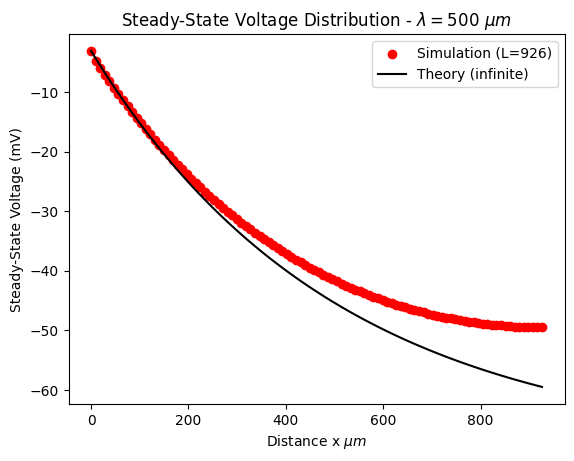

In [46]:
# @title Change the cable length L (and/or the radius). { run: "auto" }

#----------------------------------------------------------------------------
# Numerical values of key parameters
# WARNING: do not make mistakes! NEURON assumes certain units by default
# see https://www.neuron.yale.edu/neuron/static/docs/units/unitchart.html


L = 926 #@param {type:"slider", min:1, max:10000, step:5}
a = 0.5 #@param {type:"slider", min:0.1, max:5, step:0.1}

nseg = 100              # Number of segments (spatial discretization)
dx   = L/nseg           # Space step in micrometer

# By definition...
lmbd = np.sqrt(0.5*a*rm/ri)

#----------------------------------------------------------------------------
dend.L    = L              # Length   [micrometers]
dend.diam = 2*a            # Diameter [micrometers]
dend.nseg = nseg           # Number of segments (spatial discretization)

# Let's set its biophysical parameters
dend.Ra = ri               # Axial resistance [ohm cm]
dend.cm = c                # Mem capacitance  [microfarads/cm^2]

for seg in dend:
    seg.pas.g = (1./rm)  # Leak conductance [siemens/cm^2]
    seg.pas.e = -70      # Reversal potential [mV]
#----------------------------------------------------------------------------

t_stop = 1000.  # Duration of the simulation [ms]

# Let's prepare for recording time (as vector)...
t = h.Vector().record(h._ref_t)
# ...and importantly also the membrane potential at multiple locations.
# Note: locations range from 0 to 1, being a ad hoc, per-section
# coordinate representing a position on that specific section.
recording_locations = np.linspace(0, 1, nseg) # Along the dendrite (0 to 1)
v_recordings = []
for loc in recording_locations:
    v_recordings.append(h.Vector().record(dend(loc)._ref_v))

# Run the simulation
h.dt  = dt          # Time step in ms
h.finitialize(-70)  # Initialize membrane potential
h.tstop = t_stop    # Set the simulation to stop at 100 ms
h.run()

m = np.floor(t_stop/dt).astype(int)
# Extract steady-state voltage, as the last value of each recording
steady_state_v = [vv.x[m] for vv in v_recordings]

theory = [(steady_state_v[0]+70)*np.exp(-k*dx/lmbd)-70 for k in recording_locations]
# Plot the results
plt.figure()
plt.scatter(recording_locations*L, steady_state_v, marker='o', color="red")
plt.plot(recording_locations*L, theory, color="black")
#plt.xlabel('Normalized Distance [$x/\lambda$]')
plt.xlabel(r'Distance x $\mu m$')
plt.ylabel('Steady-State Voltage (mV)')
plt.title(r'Steady-State Voltage Distribution - $\lambda = {}\ \mu m$'.format(int(100*lmbd)))
label = 'Simulation (L={})'.format(L)
plt.legend([label, 'Theory (infinite)'])
plt.show()


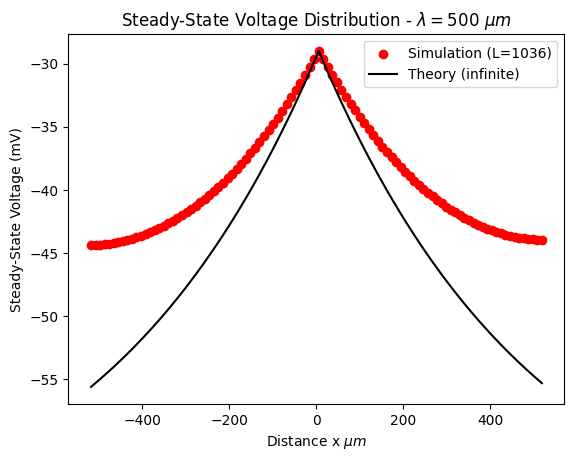

In [51]:
# @title Change the cable length L (and/or the radius). { run: "auto" }

from neuron import h              # Import the NEURON-Python library
import matplotlib.pyplot as plt   # matplotlib for plotting
import numpy as np                # numpy for linspace and other goodies

h.load_file('stdrun.hoc')         # Standard simulation environment of NEURON


#----------------------------------------------------------------------------
# Numerical values of key parameters
# WARNING: do not make mistakes! NEURON assumes certain units by default
# see https://www.neuron.yale.edu/neuron/static/docs/units/unitchart.html


L = 1036 #@param {type:"slider", min:1, max:10000, step:5}
a = 0.5 #@param {type:"slider", min:0.1, max:5, step:0.1}


#L  = 10.               # Length   [micrometers]
#a  = 2.                # Radius [micrometers]
c  = 1.                 # Mem capacitance  [microfarads/cm^2]
rm = 20000.             # Mem resistance   [Ohm/cm^2]
ri = 200.               # Axial resistance [ohm cm]

dt   = 0.025            # Time step in ms
nseg = 100              # Number of segments (spatial discretization)
dx   = L/nseg           # Space step in micrometer

# By definition...
lmbd = np.sqrt(0.5*a*rm/ri)

#----------------------------------------------------------------------------
dend      = h.Section()    # Create a section (cable) and set its morphology...
dend.L    = L              # Length   [micrometers]
dend.diam = 2*a            # Diameter [micrometers]
dend.nseg = nseg           # Number of segments (spatial discretization)

# Let's set its biophysical parameters
dend.Ra = ri               # Axial resistance [ohm cm]
dend.cm = c                # Mem capacitance  [microfarads/cm^2]

# Insert passive membrane mechanism only (i.e. no other current type)
dend.insert('pas')
for seg in dend:
    seg.pas.g = (1./rm)  # Leak conductance [siemens/cm^2]
    seg.pas.e = -70      # Reversal potential [mV]
#----------------------------------------------------------------------------

t_stop = 1000.  # Duration of the simulation [ms]

# Insert a current generator at one end (i.e. the left one)
stim        = h.IClamp(dend(0.5))
stim.delay  = 10       # Delay to onset [ms]
stim.dur    = t_stop   # Long duration to reach steady state [ms]
stim.amp    = 0.05      # Amplitude [nA]

# Let's prepare for recording time (as vector)...
t = h.Vector().record(h._ref_t)
# ...and importantly also the membrane potential at multiple locations.
# Note: locations range from 0 to 1, being a ad hoc, per-section
# coordinate representing a position on that specific section.
recording_locations = np.linspace(0, 1, nseg) # Along the dendrite (0 to 1)
v_recordings = []
for loc in recording_locations:
    v_recordings.append(h.Vector().record(dend(loc)._ref_v))

# Run the simulation
h.dt  = dt          # Time step in ms
h.finitialize(-70)  # Initialize membrane potential
h.tstop = t_stop    # Set the simulation to stop at 100 ms
h.run()

m = np.floor(t_stop/dt).astype(int)
# Extract steady-state voltage, as the last value of each recording
steady_state_v = [vv.x[m] for vv in v_recordings]

theory = [(steady_state_v[int(nseg/2)]+70)*np.exp(-np.abs(k-0.505)*dx/lmbd)-70 for k in recording_locations]
# Plot the results
plt.figure()
plt.scatter(recording_locations*L - dx*nseg/2, steady_state_v, marker='o', color="red")
plt.plot(recording_locations*L - dx*nseg/2, theory, color="black")
#plt.xlabel('Normalized Distance [$x/\lambda$]')
plt.xlabel(r'Distance x $\mu m$')
plt.ylabel('Steady-State Voltage (mV)')
plt.title(r'Steady-State Voltage Distribution - $\lambda = {}\ \mu m$'.format(int(100*lmbd)))
label = 'Simulation (L={})'.format(L)
plt.legend([label, 'Theory (infinite)'])
plt.show()


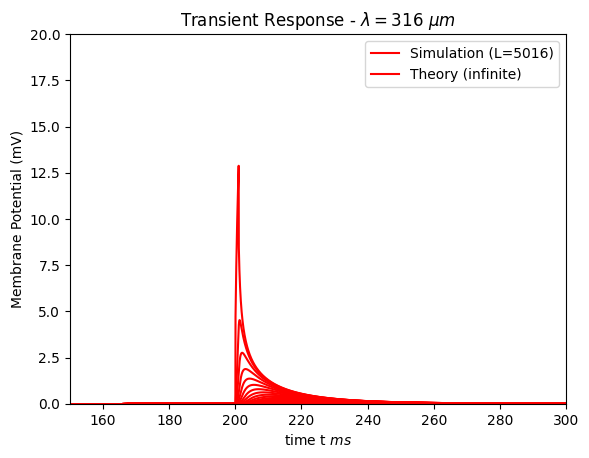

In [15]:
# @title Change the cable length L (and/or the radius). { run: "auto" }

from neuron import h              # Import the NEURON-Python library
import matplotlib.pyplot as plt   # matplotlib for plotting
import numpy as np                # numpy for linspace and other goodies

h.load_file('stdrun.hoc')         # Standard simulation environment of NEURON


#----------------------------------------------------------------------------
# Numerical values of key parameters
# WARNING: do not make mistakes! NEURON assumes certain units by default
# see https://www.neuron.yale.edu/neuron/static/docs/units/unitchart.html


L = 5016 #@param {type:"slider", min:1, max:10000, step:5}
a = 0.2 #@param {type:"slider", min:0.1, max:5, step:0.1}


#L  = 10.               # Length   [micrometers]
#a  = 2.                # Radius [micrometers]
c  = 1.                 # Mem capacitance  [microfarads/cm^2]
rm = 20000.             # Mem resistance   [Ohm/cm^2]
ri = 200.               # Axial resistance [ohm cm]

dt   = 0.025            # Time step in ms
nseg = 100              # Number of segments (spatial discretization)
dx   = L/nseg           # Space step in micrometer

# By definition...
lmbd = np.sqrt(0.5*a*rm/ri)

#----------------------------------------------------------------------------
dend      = h.Section()    # Create a section (cable) and set its morphology...
dend.L    = L              # Length   [micrometers]
dend.diam = 2*a            # Diameter [micrometers]
dend.nseg = nseg           # Number of segments (spatial discretization)

# Let's set its biophysical parameters
dend.Ra = ri               # Axial resistance [ohm cm]
dend.cm = c                # Mem capacitance  [microfarads/cm^2]

# Insert passive membrane mechanism only (i.e. no other current type)
dend.insert('pas')
for seg in dend:
    seg.pas.g = (1./rm)  # Leak conductance [siemens/cm^2]
    seg.pas.e = 0      # Reversal potential [mV]
#----------------------------------------------------------------------------

t_stop = 300.  # Duration of the simulation [ms]

# Insert a current generator at one end (i.e. the left one)
stim        = h.IClamp(dend(0.))
stim.delay  = 200       # Delay to onset [ms]
stim.dur    = 1   # Long duration to reach steady state [ms]
stim.amp    = 0.01      # Amplitude [nA]

# Let's prepare for recording time (as vector)...
t = h.Vector().record(h._ref_t)
# ...and importantly also the membrane potential at multiple locations.
# Note: locations range from 0 to 1, being a ad hoc, per-section
# coordinate representing a position on that specific section.
recording_locations = np.linspace(0, 1, nseg) # Along the dendrite (0 to 1)
v_recordings = []
for loc in recording_locations:
    v_recordings.append(h.Vector().record(dend(loc)._ref_v))

# Run the simulation
h.dt  = dt          # Time step in ms
h.finitialize(0)  # Initialize membrane potential
h.tstop = t_stop    # Set the simulation to stop at 100 ms
h.run()

#m = np.floor(t_stop/dt).astype(int)
# Extract steady-state voltage, as the last value of each recording
#steady_state_v = [vv.x[m] for vv in v_recordings]

# Plot the results
plt.figure()
for v in v_recordings:
    plt.plot(t, v.x, color="red")
#plt.xlabel('Normalized Distance [$x/\lambda$]')
plt.xlabel(r'time t $ms$')
plt.ylabel('Membrane Potential (mV)')
plt.ylim(0,20)
plt.xlim(150,300)
plt.title(r'Transient Response - $\lambda = {}\ \mu m$'.format(int(100*lmbd)))
label = 'Simulation (L={})'.format(L)
plt.legend([label, 'Theory (infinite)'])
plt.show()
